In [17]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from copy import deepcopy

In [21]:
layers = np.logspace(0, 2, 4, dtype=int)

rng = np.random.RandomState(0)
n_samples = 1000
n_test = 100
k = 10
p = 3
K = np.eye(p)
fit_loss = 'logreg'
reg = 'l1'



fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

z_true = rng.randn(p, n_samples)
D = rng.randn(k, p).dot(K)
D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = rng.randn(k, n_samples)

z_test = rng.randn(p, n_test)
eps_test = rng.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1
lbda_max = np.max(np.abs(np.dot(D.T, X)))
lbda = 0.02 * lbda_max
print('lambda = %.2e' % lbda)

lambda = 5.18e-02


In [37]:
ista_init = LISTA(D, lbda, 1, fit_loss, reg, variables='both')
ista_init.fit(X, l_rate=0.05, max_iter=10000, verbose=True)
init_weights = ista_init.weights

it 0, loss = 5.471e+00, grad_W = 1.89e-01, grad_l = 4.07e-01
it 100, loss = 5.326e+00, grad_W = 1.53e-01, grad_l = 3.22e-01
it 200, loss = 5.228e+00, grad_W = 1.27e-01, grad_l = 2.59e-01
it 300, loss = 5.160e+00, grad_W = 1.07e-01, grad_l = 2.10e-01
it 400, loss = 5.111e+00, grad_W = 9.11e-02, grad_l = 1.71e-01
it 500, loss = 5.075e+00, grad_W = 7.88e-02, grad_l = 1.40e-01
it 600, loss = 5.048e+00, grad_W = 6.85e-02, grad_l = 1.13e-01
it 700, loss = 5.027e+00, grad_W = 6.01e-02, grad_l = 9.02e-02
it 800, loss = 5.011e+00, grad_W = 5.31e-02, grad_l = 7.25e-02
it 900, loss = 4.999e+00, grad_W = 4.71e-02, grad_l = 5.60e-02
it 1000, loss = 4.989e+00, grad_W = 4.19e-02, grad_l = 4.21e-02
it 1100, loss = 4.981e+00, grad_W = 3.75e-02, grad_l = 3.03e-02
it 1200, loss = 4.975e+00, grad_W = 3.36e-02, grad_l = 1.99e-02
it 1300, loss = 4.970e+00, grad_W = 3.03e-02, grad_l = 9.87e-03
it 1400, loss = 4.965e+00, grad_W = 2.74e-02, grad_l = 1.39e-03
it 1500, loss = 4.962e+00, grad_W = 2.48e-02, grad_l

In [23]:
ista = LISTA(D, lbda, 20000, fit_loss, reg)
ista.L /= k
L = ista.L
z_hat = ista.transform(X)
f_min = loss(z_hat, X, D, lbda)

print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X)), lbda / L)))
print(f_min)

1.8642965393608472e-13
4.79007469232414


In [33]:
L_LIST = {}
for variables in ['both']:
    loss_list = {'ista': [], 'lista': []}
    for j, n_layers in enumerate(layers):
        print('%d layers' % n_layers)
        lista = LISTA(D, lbda, n_layers, fit_loss, reg, variables=variables, learn_levels=True)
        lista.weights[:2] = init_weights
        loss_ista = lista.compute_loss(X)
        loss_list['ista'].append(loss_ista)
        # smart init
        if j > 0:
            lista.weights[:len(old_weights)] = old_weights
            lista.levels[:len(old_levels)] = old_levels
        lista.fit(X, l_rate=0.05, max_iter=10000)
        loss_lista = lista.compute_loss(X)
        loss_list['lista'].append(loss_lista)
        print('Gain = %d percent' % (100 * (loss_ista - f_min) / (loss_lista - f_min)))
        old_weights = deepcopy(lista.weights)
        old_levels = deepcopy(lista.levels)
    L_LIST[variables] = loss_list

1 layers
Gain = 171 percent
4 layers
Gain = 211 percent
21 layers
Gain = 428 percent
100 layers
Gain = 1447 percent


In [34]:
lista.levels

array([0.85482753, 0.34126705, 0.42763407, 0.17481859, 0.18002262,
       0.19431629, 0.20971667, 0.22661315, 0.24420568, 0.26243837,
       0.28082626, 0.29823179, 0.31323591, 0.32330484, 0.32454402,
       0.31129817, 0.27444506, 0.20118897, 0.13604201, 0.09945721,
       0.1408127 , 0.13800018, 0.13801054, 0.13803835, 0.13807775,
       0.13812077, 0.13816896, 0.13821416, 0.13827419, 0.13833939,
       0.1384057 , 0.13847333, 0.13854664, 0.13862582, 0.13871103,
       0.13880247, 0.13890028, 0.13900468, 0.13911585, 0.13923405,
       0.13935924, 0.13949157, 0.13963117, 0.13977859, 0.13993358,
       0.14009626, 0.1402667 , 0.14044496, 0.1406311 , 0.14082523,
       0.14102745, 0.14123777, 0.14145618, 0.14168268, 0.1419173 ,
       0.14215995, 0.14241047, 0.14266866, 0.1429343 , 0.14320704,
       0.14348654, 0.14377236, 0.1440644 , 0.14436314, 0.1446679 ,
       0.14497629, 0.14528721, 0.14559935, 0.14591119, 0.14622098,
       0.14652667, 0.14682587, 0.14711586, 0.14739347, 0.14765

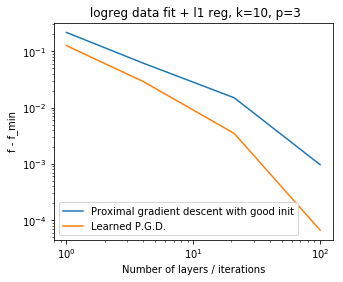

In [35]:
plt.figure(figsize=(5, 4))
title = ' %s data fit + %s reg, k=%d, p=%d' % (fit_loss, reg, k, p)
plt.title(title)
plt.plot(layers, np.array(loss_list['ista']) - f_min, label='Proximal gradient descent with good init')
plt.plot(layers, np.array(L_LIST['both']['lista']) - f_min, label='Learned P.G.D.')
plt.xlabel('Number of layers / iterations')
plt.ylabel('f - f_min')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(title + '.pdf')
plt.show()